# Lab 4: Frequency Response and Sampling
## Due Date: 03/14 @ 11:59PM on Canvas

This lab will cover the frequency response of LSI systems, the frequency content of digital signals, and sampling basics. We have some interesting applications to get to, so let's get started!

## Discrete Time Fourier Transform and Frequency Response

We will begin with a brief overview of the Discrete Time Fourier Transform (DTFT) and the frequency response of LSI systems.

The DTFT is the discrete-time version of our continuous-time Fourier transform (CTFT) from ECE 210. Like the CTFT, the DTFT is a complex-valued function that allows us to examine the frequency content of a signal or system. The DTFT is defined by

$$
X(\omega) = \sum_{n=-\infty}^{\infty}x[n]e^{-j\omega n}
$$

We also must remember that the DTFT is completely represented by digital frequencies $-\pi$ to $\pi$ and is $2\pi$ periodic. Be careful labeling your frequency axis when taking the DTFT. In Python, we are able to take the DTFT of a signal using numpy's ``fft`` module. The two main functions we will use from this module are $\textrm{numpy.fft.fft()}$ and $\textrm{numpy.fft.rfft()}$. The "fft" in these functions is the Fast Fourier Transform, which is a computationally efficient way of computing the Discrete Fourier Transform of digital signals. You will learn more about the DFT and FFT in ECE 310 and Lab 5 of this course, but for this lab just think of it as a way of computing the DTFT of a digital signal.

Let's look at example usage for these two functions and what makes them different.

In [8]:
#import libraries first
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import Audio
from scipy import signal
from scipy.io import wavfile
from skimage.io import imread
from sklearn.cluster import KMeans

%matplotlib inline

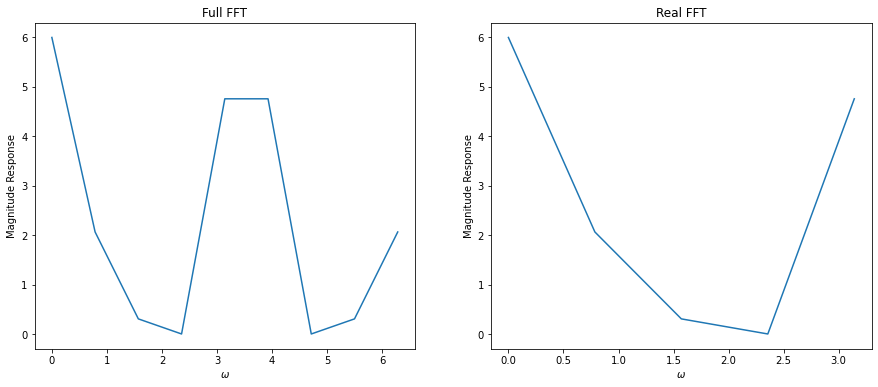

In [9]:
x = [0,1,0,2,0,2,0,1,0] #test signal

full_fft = np.fft.fft(x)
real_fft = np.fft.rfft(x)

omega_full = np.linspace(0,2*np.pi,len(full_fft)) #left limit, right limit, # pts
omega_real = np.linspace(0,np.pi,len(real_fft))

plt.figure(figsize=(15,6))
plt.subplot(121)
plt.title('Full FFT')
plt.xlabel('$\omega$')
plt.ylabel('Magnitude Response')
plt.plot(omega_full,np.absolute(full_fft))

plt.subplot(122)
plt.title('Real FFT')
plt.xlabel('$\omega$')
plt.ylabel('Magnitude Response')
plt.plot(omega_real,np.absolute(real_fft))

Observe the differences between the $\textrm{fft()}$ and $\textrm{rfft()}$ results. The way we have created the frequency axis points may have spoiled the answer, but we see that the $\textrm{fft()}$ function returns a DTFT with frequencies from 0 to $2\pi$ while $\textrm{rfft()}$ just gives us 0 to $\pi$: the *real* frequencies. It is important to acknowledge when the real frequencies are sufficient. If our signal is real-valued, we know that our spectrum will be Hermitian symmetric. In other words:

$$
x[n]\textrm{ real}\implies X(\omega) = X^*(-\omega),
$$

where $X^*$ refers to the complex conjugate of the DTFT. Why is this important? Well, if our spectrum is Hermitian symmetric, then the spectrum's magnitude response is even symmetric and its phase response is odd symmetric:

$$
x[n]\textrm{ real}\implies |X(\omega)| = |X(-\omega)|\textrm{ and }\angle X(\omega) = -\angle X(-\omega).
$$

Thus, if we want to look at the magnitude spectrum of a real-valued signal, it is sufficent to just look at the 0 to $\pi$ interval since it contains all unique information about the frequency content of our signal.

Now, let's make our plots look nicer too. We currently have a couple issues with them. First, they are very low resolution and coarse. Second, the full DTFT example is not zero-centered. Both problems can easily be fixed as follows:

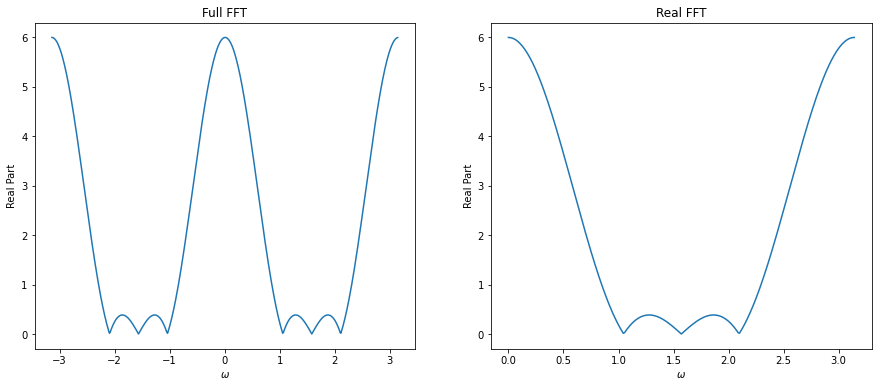

In [10]:
x = [0,1,0,2,0,2,0,1,0]

full_fft = np.fft.fft(x,512)
centered_fft = np.fft.fftshift(full_fft) #shifts central frequency to middle of array
real_fft = np.fft.rfft(x,512)

omega_full = np.linspace(-np.pi,np.pi,len(centered_fft)) #new frequency axis
omega_real = np.linspace(0,np.pi,len(real_fft))

plt.figure(figsize=(15,6))
plt.subplot(121)
plt.title('Full FFT')
plt.xlabel('$\omega$')
plt.ylabel('Real Part')
plt.plot(omega_full,np.absolute(centered_fft))

plt.subplot(122)
plt.title('Real FFT')
plt.xlabel('$\omega$')
plt.ylabel('Real Part')
plt.plot(omega_real,np.absolute(real_fft))

Those plots look so much better now! To fix our first problem with the resolution, we pass a second argument to the $\textrm{fft()}$ and $\textrm{rfft()}$ functions to specify the number of points. Do not worry about the underlying math for now, it will be covered later in ECE 310. For now, think of the number of points as dictating how many frequencies we would like to use in capturing the signal's DTFT. Try changing the number of points in the above code and observe the resolution of the DTFT. We fix the second problem by using $\textrm{np.fft.fftshift()}$ on our full DTFT result. This function zero-centers our DTFT for us along the frequency axis: how convenient!

**For the rest of this lab and in the future, it is critical you remember these tips. Always make sure your FFT has a enough points to look clean, and always make sure to appropriately label your frequency axis. Also, for this lab, when we say to "take the DTFT of a signal", use the $\textrm{np.fft.rfft()}$ function unless noted otherwise since we will only work with real signals.**

Lastly, let's see how we can look at the frequency response of an LSI system. The function we will use is $\textrm{signal.freqz()}$, which returns the normalized digital frequencies and frequency response given the numerator and denominator coefficients for an LSI system's transfer function. It is convention to plot a system's frequency response on a dB scale $\left(20\cdot\log_{10}(x)\right)$.

Text(0, 0.5, 'Magnitude Response (dB)')

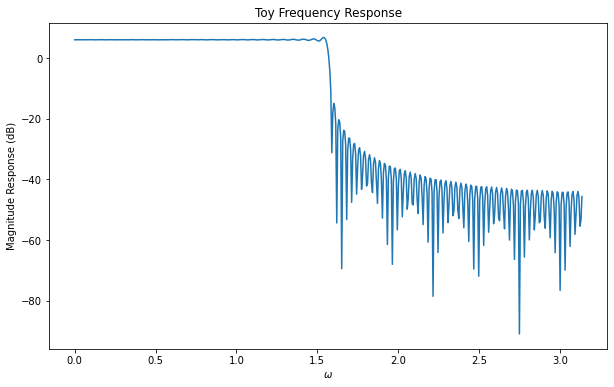

In [11]:
b = [np.sin((np.pi/2)*n)/(0.5*np.pi*n) if n != 0 else 1 for n in range(-100,101)] #numerator coefficients
a = [1,0] #denominator coefficients
w,h = signal.freqz(b,a) #w = omega/digital frequencies, h = frequency response
plt.figure(figsize=(10,6))
plt.title('Toy Frequency Response')
plt.plot(w,20*np.log10(np.absolute(h))) #plot magnitude of frequency response with db-scaling on y-axis
plt.xlabel('$\omega$')
plt.ylabel('Magnitude Response (dB)')

## Exercise 1: Implementing the DTFT

We will begin by implementing the DTFT according to the above definition for an arbitrary collection of frequencies. We will test using signals over a finite support, so we will modify our definition of the DTFT to simply say

$$
X(\omega) = \sum_{n=0}^{N-1}x[n]e^{-j\omega n}.
$$

a. Implement the $\textrm{myDTFT()}$ function below, which returns the DTFT values for a given list of digital frequencies.

b. Use your DTFT function to compute the DTFT of $x[n] = \cos(\frac{\pi}{2}n)$, $0\leq n < 50$ for 50 evenly spaced frequencies from $-\pi$ to $\pi$ (non-inclusive). Also, compute the DTFT of $x[n]$ using $\textrm{np.fft.fft()}$. Plot the magnitude and phase of the two implementations in separate figures to verify you achieve the same result. Use $\textrm{np.absolute()}$ and $\textrm{np.angle()}$ for the magnitude and phase responses, respectively. Don't forget to zero-center the frequency axis of the $\textrm{np.fft.fft()}$ result using $\textrm{np.fft.fftshift()}$.

c. Theoretically, the DTFT of $\cos(\omega_0n)$ should give us Kronecker deltas at $\pm\omega_0$. However, we see our implementation and the numpy DTFT function result in some non-ideal representation, like in the ramping behavior around the frequencies of the cosine. Why does this happen? Hint: consider how our practical definition of the DTFT in this exercise differse from the theoretical definition of the DTFT. 

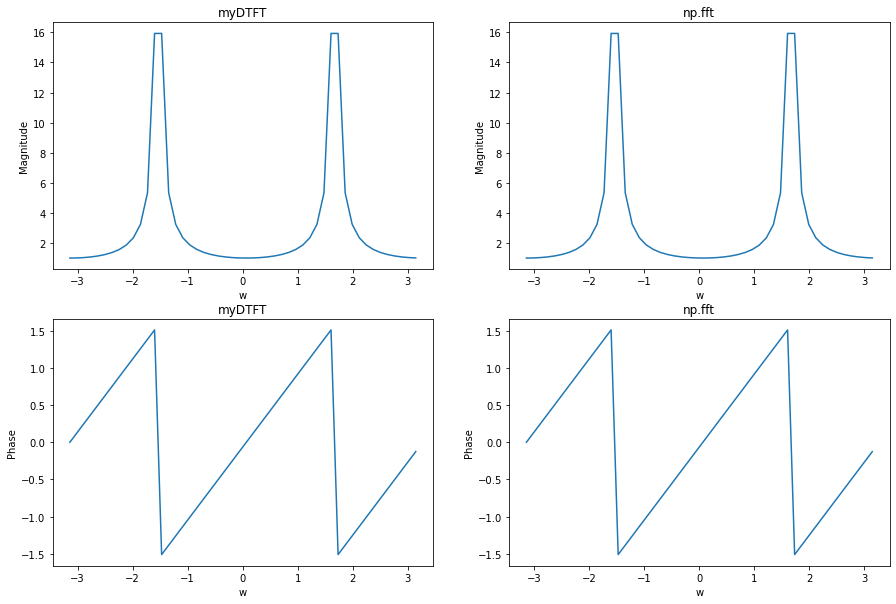

In [12]:
#Function to implement for part 1.a:
"""
Inputs:
x - input signal (list or np.array)
w - frequencies we want to compute the DTFT for (list or np.array)
Output:
dtft - value of the DTFT for signal x at each frequency specified in w (list or np.array)
"""
def myDTFT(x,w):
    dtft = [] #create empty list to append resulting computation
    for frequency in w: #Iterate over each frequency in w
        s = 0#Compute summation for current frequency according to our DTFT definition, "1j" gives you the imaginary number
        for n in range(len(x)):
            s += x[n] * np.exp(-1j * frequency * n)
    #Append result for current frequency
        dtft.append(s)    
    return dtft

#Code for part 1.b:
x = np.array([np.cos(0.5*np.pi*n) for n in range(50)])
#endpoint argument makes sure our definition aligns with the np.fft.fft result
w = np.linspace(-np.pi,np.pi,50,endpoint=False)

DTFT = myDTFT(x, w)
FFT = np.fft.fft(x, len(w))

DTFTcentre = np.fft.fftshift(DTFT)
FFTcentre = np.fft.fftshift(FFT)

fullw = np.linspace(-np.pi, np.pi, len(DTFTcentre))
realw = np.linspace(-np.pi, np.pi, len(FFTcentre))


plt.figure(figsize = (15, 10))
plt.subplot(221)
plt.title('myDTFT')
plt.xlabel('w')
plt.ylabel('Magnitude')
plt.plot(realw, np.absolute(DTFTcentre))

plt.subplot(222)
plt.title('np.fft')
plt.xlabel('w')
plt.ylabel('Magnitude')
plt.plot(fullw, np.absolute(FFTcentre))

plt.subplot(223)
plt.title('myDTFT')
plt.xlabel('w')
plt.ylabel('Phase')
plt.plot(realw, np.angle(DTFTcentre))

plt.subplot(224)
plt.title('np.fft')
plt.xlabel('w')
plt.ylabel('Phase')
plt.plot(fullw, np.angle(FFTcentre))


Answer for part 1.c: We used finite limited number of samples, but DTFT should theoretically be calculated based on infinite sum. So the calculation shown above could not reveal the complete picture of the DTFT of the cosine function.

## Exercise 2: Toy LSI Signals and Systems

For this exercise, we will get some practice with inspecting the DTFT of digital signals and frequency response of LSI systems. For parts 2.a and 2.b, plot the resulting magnitude and phase of the DTFT of each signal. Please place the two plots for each signal side-by-side using $\textrm{plt.subplot()}$. Don't forget to specify a larger number of points in your DTFT like 512. For parts 1.c and 1.d, plot the magnitude response of each system as shown above using $\textrm{signal.freqz()}$ use a dB scaling on the y-axis.

$\begin{align}
a. x_1[n] = \frac{1}{4}\delta[n]+\frac{1}{2}\delta[n-1] + \delta[n-2] + \frac{1}{2}\delta[n-3] + \frac{1}{4}\delta[n-4]
\end{align}$

$\begin{align}
b. x_2[n] = -\delta[n] + 2\delta[n-2] - \delta[n-4]
\end{align}$

$\begin{align}
c. H_3(z) = \frac{z^2 -2z + 1}{z^2 -\frac{1}{2}z + \frac{1}{4}}
\end{align}$

$\begin{align}
d. H_4(z) = \frac{z^4 + 2z^3 + z^2}{z^4-\frac{1}{2}z^3+\frac{1}{4}z^2-\frac{1}{8}z + \frac{1}{16}}
\end{align}$


C:\Users\dylan\AppData\Local\Temp/ipykernel_1452/1625899272.py:50: RuntimeWarning: divide by zero encountered in log10
  plt.plot(w, 20*np.log10(np.absolute(h)))


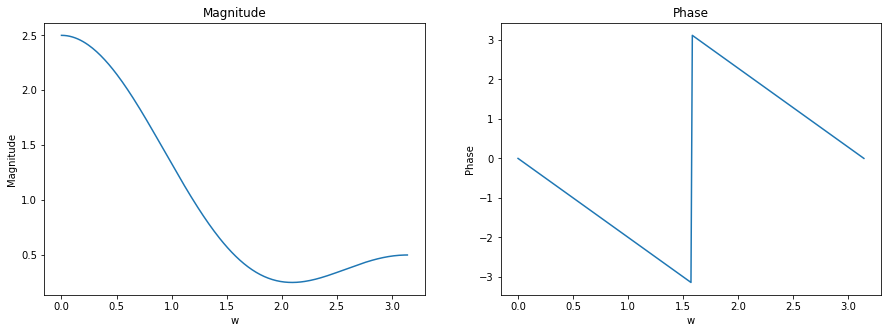

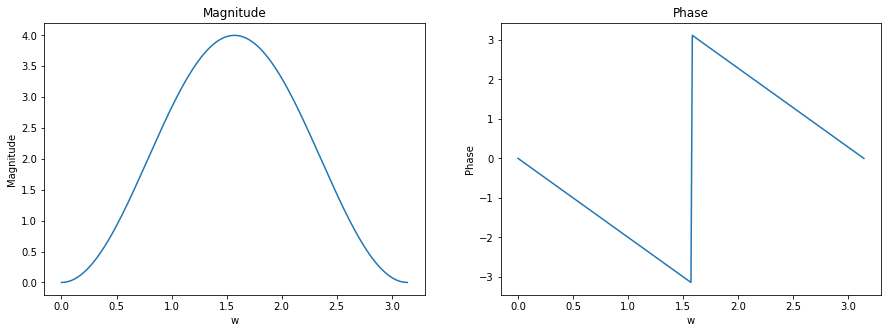

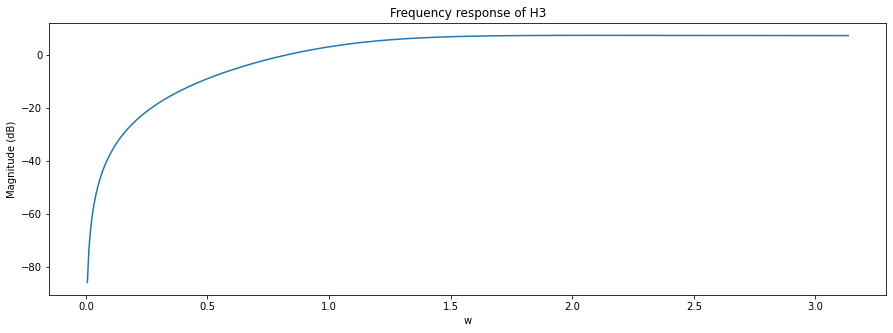

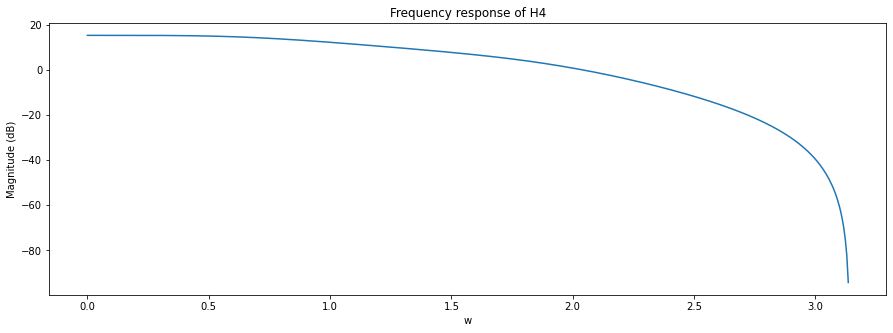

In [13]:
#Code for 2.a:
#Remember to plot magnitude and phase of signals side-by-side with plt.subplot(nrows,ncols,plot number)

x1 = [0.25, 0.5, 1, 0.5, 0.25]
x1fft = np.fft.rfft(x1, 512)
w_x1 = np.linspace(0, np.pi, len(x1fft))

plt.figure(figsize = (15, 5))
plt.subplot(121)
plt.title('Magnitude')
plt.xlabel('w')
plt.ylabel('Magnitude')
plt.plot(w_x1, np.absolute(x1fft))

plt.subplot(122)
plt.title('Phase')
plt.xlabel('w')
plt.ylabel('Phase')
plt.plot(w_x1, np.angle(x1fft))

#Code for 2.b:

x2 = [-1, 0, 2, 0, -1]
x2fft = np.fft.rfft(x2, 512)
w_x2 = np.linspace(0, np.pi, len(x2fft))

plt.figure(figsize = (15, 5))
plt.subplot(121)
plt.title('Magnitude')
plt.xlabel('w')
plt.ylabel('Magnitude')
plt.plot(w_x2, np.absolute(x2fft))

plt.subplot(122)
plt.title('Phase')
plt.xlabel('w')
plt.ylabel('Phase')
plt.plot(w_x2, np.angle(x2fft))

#Code for 2.c:
#Remember to plot magnitude response with dB-scaling on y-axis.

b = [1, -2, 1]
a = [1, -0.5, 0.25]
w, h = signal.freqz(b, a)
plt.figure(figsize = (15, 5))
plt.title('Frequency response of H3')
plt.xlabel('w')
plt.ylabel('Magnitude (dB)')
plt.plot(w, 20*np.log10(np.absolute(h)))

#Code for 2.d:

b = [1, 2, 1]
a = [1, -0.5, 0.25, -0.125, 0.0625]
w, h = signal.freqz(b, a)
plt.figure(figsize = (15, 5))
plt.title('Frequency response of H4')
plt.xlabel('w')
plt.ylabel('Magnitude (dB)')
plt.plot(w, 20*np.log10(np.absolute(h)))



## Sinusoidal Response of LSI Systems

We recall from ECE 210 that the response of LTI systems to sinusoidal inputs has a nice closed form using the frequency response of our system. The same is true for our discretized LSI systems! Let $H(\omega)$ be our frequency response and our input be some sinusoidal input with arbitrary amplitude $A$, frequency $\omega_0$, and phase $\theta$:

$$
A\sin(\omega_0n + \theta) \to \begin{bmatrix}H(\omega)\end{bmatrix} \to A|H(\omega_0)|sin(\omega_0n + \theta + \angle H(\omega_0))
$$

We see that the output is simply the input signal scaled by the magnitude response and we add phase according the value of the phase response at the sinusoid's frequency. Furthermore, we can extend this notion to sums of sinusoids by the linearity of our LSI systems. Now, let's verify this with an example system!

## Exercise 3: Sinusoidal Response of an LSI System

For all parts of this problem, we will consider the following LSI system:

$$
h[n] = \frac{1}{2}\delta[n] + \delta[n-2] + \frac{1}{2}\delta[n-4]
$$

a. Plot the magnitude and phase response of the above system. Do not use a dB-scale when plotting this system. Use 512 for the number of points in your DTFT. Verify your results by computing the frequency response by hand.

Consider the following two inputs:

$\begin{align}
\bullet~x_b[n] = 1 + 2\sin\left(\frac{\pi}{4}n\right), \quad 0\leq n < 100
\end{align}$

$\begin{align}
\bullet~x_c[n] = 2 + 10\sin\left(\frac{\pi}{2}n\right) + 4\cos\left(\pi n\right), \quad 0\leq n < 100
\end{align}$

b. Apply the filter $h[n]$ to input $x_b[n]$ using $\textrm{signal.lfilter()}$. Plot the magnitude of the DTFT for the input and filtered output, respectively, on separate subplots. Use 512 points again for your DTFT. Verify these results by hand!

c. Apply the filter $h[n]$ to input $x_c[n]$. Plot the magnitude of the DTFT for the input and filtered output, respectively, on separate subplots. Also verify these results by hand!

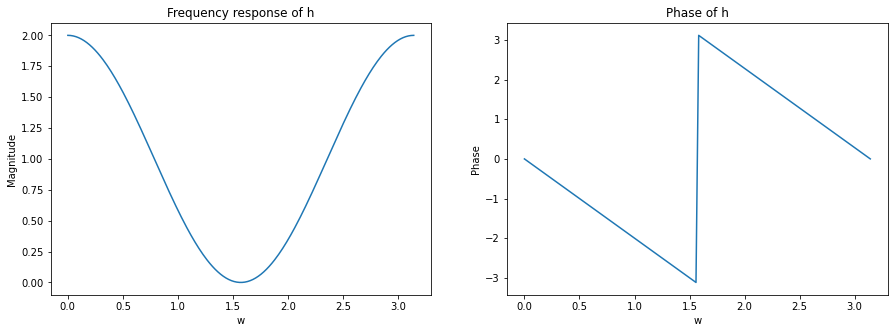

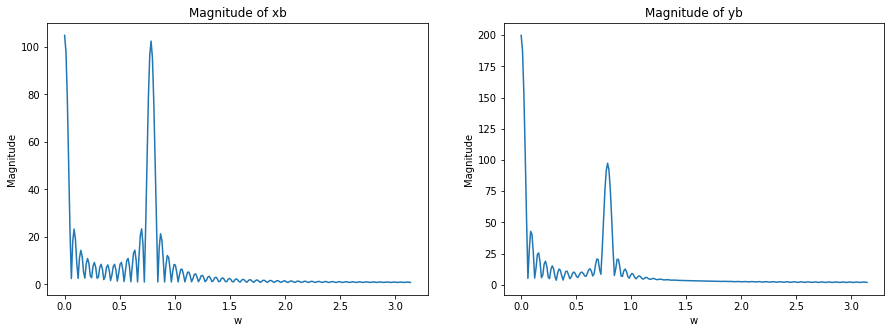

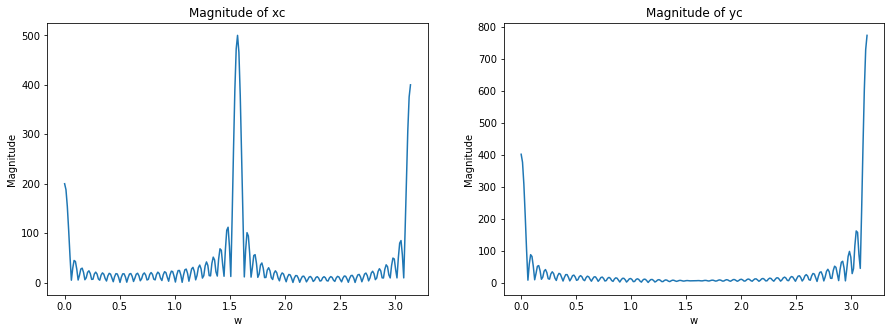

In [15]:
#Code for part 3.a:

h = [0.5, 0, 1, 0, 0.5]
x1fft = np.fft.rfft(h, 512)
w_x1 = np.linspace(0, np.pi, len(x1fft))

plt.figure(figsize = (15, 5))
plt.subplot(121)
plt.title('Frequency response of h')
plt.xlabel('w')
plt.ylabel('Magnitude')
plt.plot(w_x1, np.absolute(x1fft))

plt.subplot(122)
plt.title('Phase of h')
plt.xlabel('w')
plt.ylabel('Phase')
plt.plot(w_x1, np.angle(x1fft))

#Code for part 3.b:

xb = np.array([1 + 2 * np.sin(0.25 * np.pi * n) for n in range(0, 100)])

b = [1, 0, 2, 0, 1]
a = [2, 0, 0, 0, 0]

yb = signal.lfilter(b, a, xb)
ybrfft = np.fft.rfft(xb, 512)
ybrfft_filtered = np.fft.rfft(yb, 512)
w_xb = np.linspace(0, np.pi, len(ybrfft))

plt.figure(figsize = (15, 5))
plt.subplot(121)
plt.title('Magnitude of xb')
plt.xlabel('w')
plt.ylabel('Magnitude')
plt.plot(w_xb, np.absolute(ybrfft))

plt.subplot(122)
plt.title('Magnitude of yb')
plt.xlabel('w')
plt.ylabel('Magnitude')
plt.plot(w_xb, np.absolute(ybrfft_filtered))


#Code for part 3.c:

xc = np.array([2 + 10 * np.sin(0.5 * np.pi * n) + 4 * np.cos(np.pi * n) for n in range(0, 100)])

b = [1, 0, 2, 0, 1]
a = [2, 0, 0, 0, 0]

yc = signal.lfilter(b, a, xc)
ycrfft = np.fft.rfft(xc, 512)
ycrfft_filtered = np.fft.rfft(yc, 512)
w_xc = np.linspace(0, np.pi, len(ycrfft))

plt.figure(figsize = (15, 5))
plt.subplot(121)
plt.title('Magnitude of xc')
plt.xlabel('w')
plt.ylabel('Magnitude')
plt.plot(w_xb, np.absolute(ycrfft))

plt.subplot(122)
plt.title('Magnitude of yc')
plt.xlabel('w')
plt.ylabel('Magnitude')
plt.plot(w_xb, np.absolute(ycrfft_filtered))



## Exercise 4: Yanny or Laurel? Why not both?

For this next exercise, we will visualize the effects of applying LSI systems as filters by looking in the frequency domain. But let's work with something more interesting than toy systems or signals: the infamous "Yanny or Laurel?" audio clip we used in Lab 1. Some people hear Yanny while others hear Laurel. In this activity, we will show using signal processing that both are audible and hopefully shed some light on this auditory illusion.

We have provided two filters in the files ``filter-one.npy`` and ``filter-two.npy`` in addition to the audio clip. Do not worry about the design of these filters. We will cover filter design in more detail in Lab 6. 

a. Use $\textrm{np.load()}$ to load each filter. Note that these coefficients are simply the numerator coefficients of the transfer functions. We will assume a denominator of 1. Plot the magnitude of the DTFT for the audio signal using $\textrm{np.fft.rfft()}$ and the frequency response for each filter using $\textrm{signal.freqz()}$.

b. Apply each filter to the audio clip using $\textrm{signal.lfilter()}$. Listen to the results from each filter. **As always, be careful with your volume before listening**.

c. What sounds different in each filtered audio clip? Does this explain the auditory illusion? If so, how? If you are having trouble hearing a difference, try changing the playback sampling frequency for the filtered results a little ($\pm$10-20%).

In [41]:
fs,audio = wavfile.read('audiofile.wav') #load the data
print(audio.shape) #one channel

(34752,)


In [42]:
Audio(data = audio,rate = fs) #give it a listen for reference

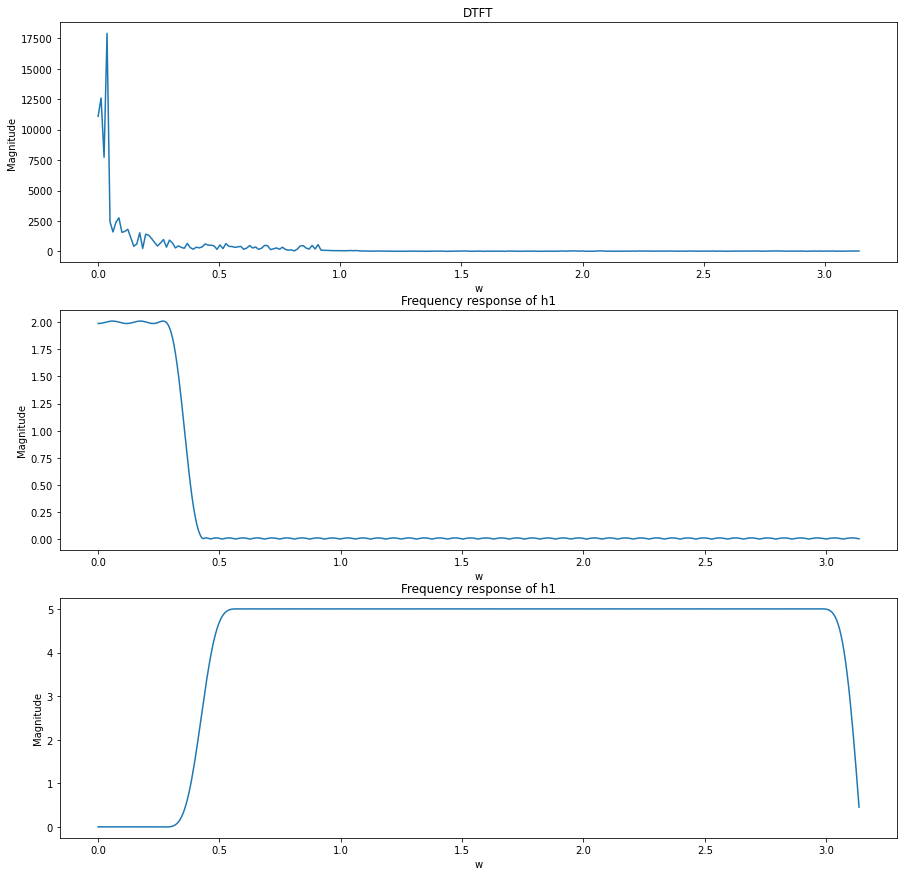

In [44]:
#Code for 4.a
h1 = np.load('filter-one.npy')
h2 = np.load('filter-two.npy')
b1 = h1
b2 = h2
a1 = 1
a2 = 2


fft_audio = np.fft.rfft(audio, 512)
w_audio = np.linspace(0, np.pi, len(fft_audio))

w1, h1 = signal.freqz(h1)
w2, h2 = signal.freqz(h2)

plt.figure(figsize = (15, 15))
plt.subplot(311)
plt.title('DTFT')
plt.xlabel('w')
plt.ylabel('Magnitude')
plt.plot(w_audio, np.absolute(fft_audio))

plt.subplot(312)
plt.title('Frequency response of h1')
plt.xlabel('w')
plt.ylabel('Magnitude')
plt.plot(w1, np.absolute(h1))

plt.subplot(313)
plt.title('Frequency response of h1')
plt.xlabel('w')
plt.ylabel('Magnitude')
plt.plot(w2, np.absolute(h2))

#Code for 4.b

audio_result1 = signal.lfilter(b1, a1, audio)
audio_result2 = signal.lfilter(b2, a2, audio)


In [45]:
#Make sure to typecast audio before listening to it as follows:
audio_result1 = audio_result1.astype(np.int16)
audio_result2 = audio_result2.astype(np.int16)

In [46]:
#Listen to result 1 here!
Audio(data = audio_result1,rate = fs)

In [47]:
#List to result 2 here!
Audio(data = audio_result2,rate = fs)

Comments for 4.c here: The sound of the voice filtered by h1 is lower than that by h2 because h1 has cut out high frequencies while h2 has cut out low frequencies. Although I have heard "Laurel" from both of the audio, the second one is much higher than the first one.


## Sampling and Analog-to-Digital Conversion

For the second half of this lab, we will focus on the process of sampling and storing digital signals. We will begin with some review.

When sampling a continuous time signal, we must be careful to sample at an appropriate frequency. For any bandlimited signal with a maximum frequency of $f_{max}$ or bandwidth $B$, we can guarantee no aliasing if we sample above twice $f_{max}$. This is known as the Nyquist criterion:

$$
f_s > 2B = f_{Nyquist}.
$$

How can we relate the analog and digital frequencies before and after sampling? There is a simple equation for that!

$$
\omega_d = \Omega_aT,
$$

where $T$ is the sampling period, $\omega_d$ is our digital frequency, and $\Omega_a$ is the analog frequency. Recall that the DTFT of a digital signal is $2\pi$ periodic and our digital frequencies are bounded between $-\pi$ and $\pi$. For example, suppose we have a signal $x(t)$ with $f_{max}$ = 35kHz and we sample at $f_s = 30kHz$. Where will this maximum frequency lie in the digital spectrum?

$$
\omega_d = 2\pi\cdot35000\cdot\frac{1}{30000}
$$

$$
\omega_d = \frac{7\pi}{3}
$$

Clearly, we have sampled below the Nyquist rate, and thus the signal has aliased. The max frequency directly maps to $\frac{7\pi}{3}$; however, by the $2\pi$ periodicity of the DTFT, we will also have a frequency component at $\frac{7\pi}{3}-2\pi = \frac{\pi}{3}$ in the central copy of the DTFT. Excercise 5 will give you some practice with different sampling rates and how to explain aliasing.

In ECE 310, we mainly focus on the sampling part of the analog-to-digital conversion process. Don't forget that in practice we must consider quantization effects. We cannot store every possible analog value of a signal, so we must select a finite number of levels to represent our data. Most simply in ECE 110, we learn about uniform quantizers where the levels are evenly spaced throughout the dynamic range (range of possible values). Each captured sample is "rounded" or quantized to its nearest level. But we should also consider other quantization schemes. For example, what if most of our analog samples densely range between 0V-1V, while a few noisy samples spike up to 5V. A uniform quantizer would lose resolution at lower voltages and accomodate the noisy samples too much. Perhaps there is a better way? Excercise 6 will show you an example of a non-uniform quantizer and let you compare it with a uniform quantizer on a couple test images.

## Exercise 5: It's a bird! It's a plane! No, it's just aliasing!

We will now get some hands-on experience with aliasing and sampling effects. Python has a helpful function in the ``scipy.signal`` package called $\textrm{signal.chirp()}$ that generates a swept cosine signal. This means we can create a sweeping tone between a start and end frequency. Unfortunately, the documentation for this function is a bit confusing, so let's briefly demonstrate its usage:

In [55]:
Fs = 44100 #sampling rate for audio clip in Hz
t1 = 5 #make clips 5 seconds
t = np.linspace(0,t1,t1*Fs) #make sure to specify the number of points to match desired sampling frequency!!!
f0 = 0 #start frequency (Hz)
f1 = 22050 #end frequency (Hz)

"""
instantanous frequency, f(t) = f0 + (f1-f0)*(t/t1)
"""

chirp_original = signal.chirp(t,f0 = f0, t1 = t1, f1 = f1)

In [56]:
#BE CAREFUL WITH YOUR VOLUME! CHIRP SEQUENCES CAN BE LOUD!

Audio(data = chirp_original,rate = Fs) #give it a listen

We will now inspect the signals we create and try changing the sampling rate.  Once again, be careful when listening to audio.

a. Plot the magnitude of the DTFT of the ``chirp_original`` signal. Plot your frequency axis in digital frequency (0 to $\pi$). What is the maximum frequency our sound card can represent for the sampling frequency used to generate this signal?

b. Generate a second chirp with a sampling frequency of 29,400. Assume the same $t_1$, $f_0$, and $f_1$ from above. Listen to the resulting audio and plot the magnitude of the DTFT for this chirp. Explain what you hear (why do you hear what you hear) and relate it to your DTFT plot. Remember to share the same sampling frequency between generating the time sequence and your soundcard like in the above example.

c. Suppose we wanted to hear three complete rises and two complete falls in the generated chirp. What sampling frequency should we specify when generating the audio chirp to achieve this strange goal? Briefly explain how you arrived at your answer.

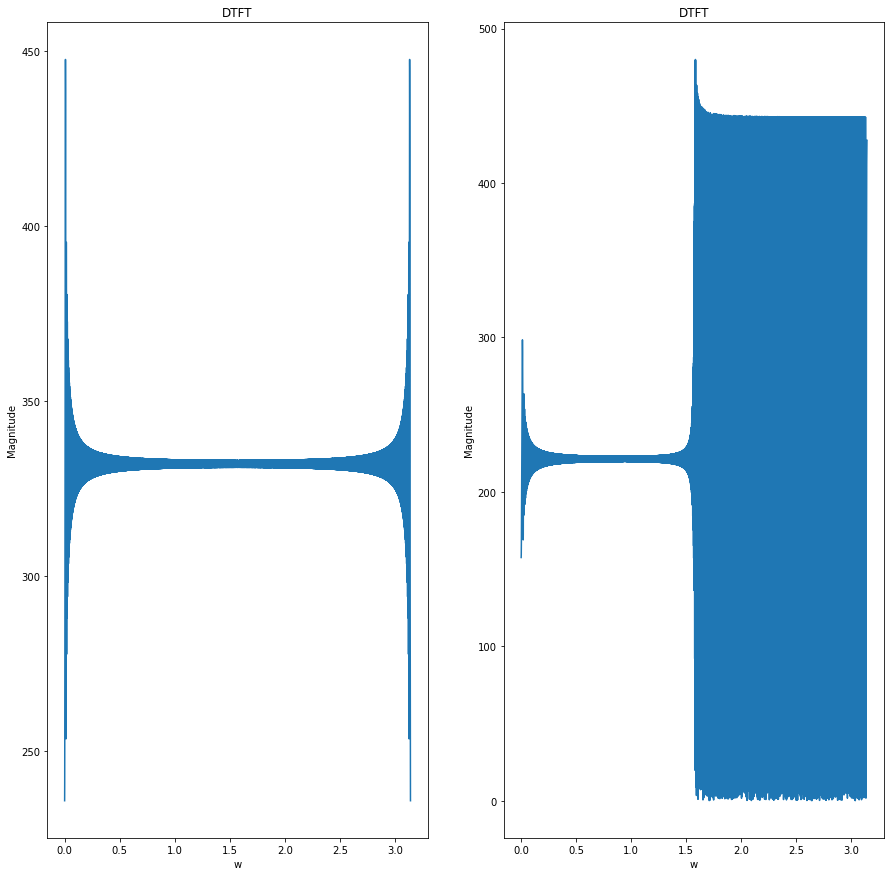

In [59]:
#Code for 5.a here:

fft_audio = np.fft.rfft(chirp_original)
w_audio = np.linspace(0, np.pi, len(fft_audio))
plt.figure(figsize = (15, 15))
plt.subplot(121)
plt.title('DTFT')
plt.xlabel('w')
plt.ylabel('Magnitude')
plt.plot(w_audio, np.absolute(fft_audio))

#Code for 5.b here:

t = np.linspace(0, t1, 29400 * t1)
current_chirp = signal.chirp(t, f0 = f0, t1 = t1, f1 = f1)
fft2 = np.fft.rfft((current_chirp))
w2 = np.linspace(0, np.pi, len(fft2))
plt.subplot(122)
plt.title('DTFT')
plt.xlabel('w')
plt.ylabel('Magnitude')
plt.plot(w2, np.absolute(fft2))

current_fs = 29400


In [60]:
#Code cell to listen to different chirps you generate
Audio(data = current_chirp,rate = current_fs) #Remember to use correct sampling frequency!

Answers for 5.a: The max frequency should be 22050 Hz.
    

Answers for 5.b: There should be more aliasing in the second audio that cause the audio to sound different. There're a rise and a fall in the second one while the fall in the first one can't be heard, or there's no fall in the first audio.


Answers for 5.c: We'll have 2.5 complete periods of the signal, so the sampling frequency should be f1 / 2.5 = 22050 * 0.4 = 8820 Hz.



## Exercise 6: Which Crayons Should You Use?

You are a new hire at Crayola; the crayons division, to be specific. Your title is "Swiss-Army Knife of Signal Processing", or at least that's what your business cards say. Your team is working on a new problem from customer feedback. Parents are sick of buying huge crayon packs where their kids don't use all the colors. It's a waste! There is a new initiative to deliver coloring packs to consumers where they get a coloring book and a select group of crayons that include all the colors they will need to create their masterpieces. So, the question is: how do we best pick the colors in the crayon pack?

Your predecessor came up with a naive solution where you simply create a uniform quantizer with evenly spaced levels for the desired number of colors. However, there are a couple problems with this:

* This solution only works for grayscale pictures.
* It works poorly for very bright or dark images. We don't use all the colors!

Before you improve on this system, let's first implement it ourself as a baseline for comparison. Note, for the following three parts, you may play around with the value of $k$. Try values in the range of 2-16. Before turning your lab in, you may fix $k$ to be 4 for each part.

a. Fill in the below function $\textrm{uniform_quantizer()}$ that implements this uniform color quantizer. Test your function on the ``grayscale-test.jpg`` image. Plot the original and quantized images side-by-side.

Now, you know a great fix to make sure all the crayons are used and the colored-in image looks close to the original one. You are going to use Lloyd-max quantization, which is commonly referred to as k-means clustering! Do not worry too much about the math of k-means clustering, the quantization function is provided for you below and your answers for the last part may be qualitative. **Note: The code to perform Lloyd-max quantization may take a minute or two to run.**

b. Test the $\textrm{lm_quantizer()}$ function on the ``grayscale-test.jpg`` image and plot the original and quantized images side-by-side.

Another advantage of Lloyd-Max quantization/k-means clustering is that it extends easily to multiple dimensions, like color images. In fact, we can use the same function for both types of images!

c. Test the $\textrm{lm_quantizer()}$ function on the ``color-test.jpg`` image and plot the original and quantized images side-by-side.

d. Compare the results from the uniform and Lloyd-Max quantizers. How does the Lloyd-Max quantizer appear to work differently? You may explain your observations qualitatively or quantitatively. If you need help explaining, you can read up on k-means <a href="https://en.wikipedia.org/wiki/K-means_clustering">here</a> or <a href="http://scikit-learn.org/stable/modules/clustering.html#k-means">there</a>.

In [62]:
#Part 6.a
#Fill in the below function!
"""
image - image we want to color quantize
k - number of quantization levels (# of crayons)
For example, k = 4 means we will have levels at 0, 85, 170, and 255.

returns: q_image = color quantized image
"""
def uniform_quantizer(image,k):
    #create quantization levels
    levels = np.linspace(0,255,k) #k evenly spaced colors from 0 (black) to 255 (white)
    #create a new/blank version of the image and compute quantization level spacing
    q_image = np.zeros(image.shape)
    spacing = 255/(k-1)
    #go through each pixel in the original image, assign quantized value to new/blank image
    #remember we choose the quantization level closest to the original value
    n_rows, n_cols = image.shape
    for i in range(n_rows):
        for j in range(n_cols):
            x = np.searchsorted(levels, image[i, j], side = 'left')
            q_image[i, j] = levels[x]
    #return your quantized image
    return q_image


#Part 6.b/6.c
#Function has been provided for you!
"""
image - image we want to color quantize
k - number of quantization levels

returns: q_image = color quantized image
"""
def lm_quantizer(image,k):
    im_shape = image.shape
    n_rows = im_shape[0]
    n_cols = im_shape[1]
    #create k-means object
    kmeans = KMeans(n_clusters = k)
    #reshape pixel value to be like data points
    if len(im_shape) == 2:
        pixel_vals = np.array([[image[row,col]] for row in range(n_rows) for col in range(n_cols)])
    else:
        pixel_vals = np.array([image[row,col] for row in range(n_rows) for col in range(n_cols)])
    #fit the k-means model to pixel data and get color labels
    color_labels = kmeans.fit_predict(pixel_vals)
    #create blank version of the image
    q_image = np.zeros(im_shape).astype(np.uint8)
    #assign appropriate color to each pixel based on color labels
    colors = kmeans.cluster_centers_.astype(np.uint8)
    for i,label in enumerate(color_labels):
        q_image[int(i/n_cols),i % n_cols] = colors[label]
    return q_image

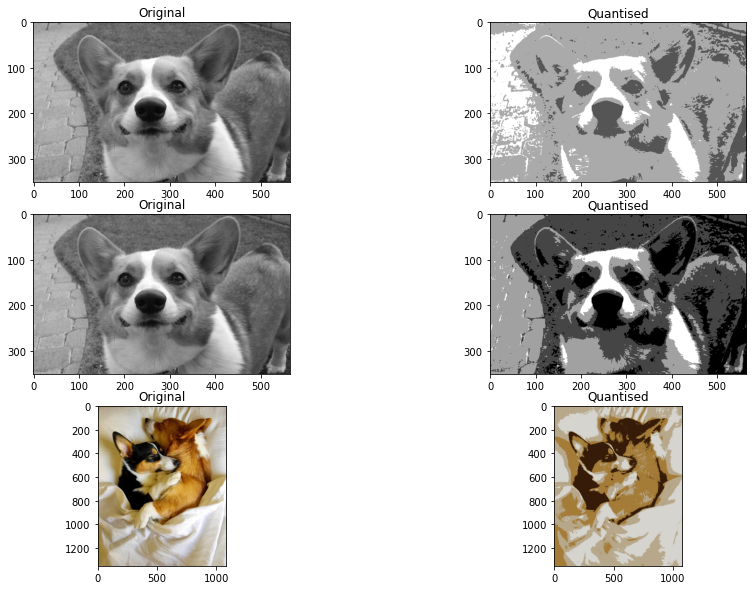

In [66]:

k = 4
img = imread('grayscale-test.jpg')

#Code to test 6.a

a = uniform_quantizer(img, k)
plt.figure(figsize = (15, 10))
plt.subplot(321)
plt.title('Original')
plt.imshow(img, 'gray')
plt.subplot(322)
plt.title('Quantised')
plt.imshow(a, 'gray')


#Code to test 6.b

b = lm_quantizer(img, k)
plt.subplot(323)
plt.title('Original')
plt.imshow(img, 'gray')
plt.subplot(324)
plt.title('Quantised')
plt.imshow(b, 'gray')

#Code to test 6.c

img_colour = imread('color-test.jpg')
c = lm_quantizer(img_colour, k)
plt.subplot(325)
plt.title('Original')
plt.imshow(img_colour)
plt.subplot(326)
plt.title('Quantised')
plt.imshow(c)


Answer for 6.d here: The K-means clustering will find the average of the surrounding values at the selected pixels to be quantised. The quantisation of the pixels will base on the average values. This makes LM quantiser more accurate than the uniform quantiser.


## Submission Instructions

Please rename this notebook to "netid_Lab4" and submit a zip file including all the supplied files for this lab to Canvas. Please also name your zip file submission "netid_Lab4".